In [ ]:
!pip install -qq transformers accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 29.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.4/261.4 kB 29.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.7/311.7 kB 31.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 66.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 65.7 MB/s eta 0:00:00


In [ ]:
import re
import random

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report, accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset
import transformers
from transformers import AutoModelForSequenceClassification, AutoTokenizer, Trainer, TrainingArguments, pipeline
from transformers.data.processors.utils import InputFeatures

In [ ]:
## Setting Device

if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [ ]:
## Seeding RNGs for reproducible training

SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [ ]:
print(torch.__version__)
print(transformers.__version__)

2.1.0+cu118
4.35.2


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/MyDrive/Dataset.tsv', sep='\t')
df.shape

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


(97554, 2)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97554 entries, 0 to 97553
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    97552 non-null  object
 1   label   97551 non-null  object
dtypes: object(2)
memory usage: 1.5+ MB


In [ ]:
DATA_COLUMN = "text"
LABEL_COLUMN = "label"

In [ ]:
df.head(n=10)

,text,label
0,ممتاز نوعا ما . النظافة والموقع والتجهيز والشا...,Positive
1,أحد أسباب نجاح الإمارات أن كل شخص في هذه الدول...,Positive
2,هادفة .. وقوية. تنقلك من صخب شوارع القاهرة الى...,Positive
3,خلصنا .. مبدئيا اللي مستني ابهار زي الفيل الاز...,Positive
4,ياسات جلوريا جزء لا يتجزأ من دبي . فندق متكامل...,Positive
5,أسلوب الكاتب رائع جدا و عميق جدا، قرأته عدة مر...,Positive
6,استثنائي. الهدوء في الجناح مع مسبح. عدم وجود ع...,Positive
7,الكتاب هو السيرة الذاتية للحداثة في المملكة بل...,Positive
8,من أجمل ما قرأت.. رواية تستحق القراءة فعلا..,Positive
9,بشكل عام جيده .. . التجاوب جيد جدا من قبل موظف...,Positive


In [ ]:
df.tail(n=10)

,text,label
97544,بسم الله الرحمن الرحيم. وأنه كان رجال من الإنس...,Negative
97545,ضعيف جدا. لا شي نهائيا. استقبال السوداني جدا ج...,Negative
97546,الفندق مخيب ودون المستوى . . تأخير عند الاستقب...,Negative
97547,لم اجد فيها شيء مميز لا اعتقد انها تستحق ان تك...,Negative
97548,تقييم منصف للفندق الرديء الجودة الغالي السعر ....,Negative
97549,معرفش ليه كنت عاوزة أكملها وهي مش عاجباني من ا...,Negative
97550,لا يستحق ان يكون في بوكنق لانه سيئ . لا شي. لا...,Negative
97551,كتاب ضعيف جدا ولم استمتع به. فى كل قصه سرد لحا...,Negative
97552,مملة جدا. محمد حسن علوان فنان بالكلمات، والوصف...,Negative
97553,لن ارجع إليه مرة اخرى . قربه من البحر. المكان ...,Negative


In [ ]:
df[LABEL_COLUMN].value_counts()

Negative    32600
Mixed       32535
Positive    32416
Name: label, dtype: int64

In [ ]:
df.isnull().sum()

text     2
label    3
dtype: int64

In [ ]:
df=df.dropna(axis=0)
df.isnull().sum()

text     0
label    0
dtype: int64

In [ ]:
# Splitting the dataset again into train/test datasets
train_main, test_main = train_test_split(df, test_size=0.3, shuffle=True, random_state=SEED, stratify=df[LABEL_COLUMN])
label_list_main = list(df[LABEL_COLUMN].unique())

print("Training length: ", len(train_main))
print(train_main[LABEL_COLUMN].value_counts(), '\n')

print("Testing length: ", len(test_main))
print(test_main[LABEL_COLUMN].value_counts())

Training length:  68284
Negative    22820
Mixed       22774
Positive    22690
Name: label, dtype: int64 

Testing length:  29265
Negative    9780
Mixed       9761
Positive    9724
Name: label, dtype: int64


In [ ]:
label_list_df_main = list(df[LABEL_COLUMN].unique())
print(label_list_df_main)

['Positive', 'Mixed', 'Negative']


In [ ]:
class CustomDataset:

    def __init__(self, name: str, train: pd.DataFrame, test: pd.DataFrame, label_list: list[str]):
        self.name = name
        self.train = train
        self.test = test
        self.label_list = label_list

In [ ]:
data_main = CustomDataset("quizDataset", train_main, test_main, label_list_df_main)

In [ ]:
print(data_main.name)
print(data_main.label_list)
print("Number of Labels:", len(data_main.label_list))

quizDataset
['Positive', 'Mixed', 'Negative']
Number of Labels: 3


In [ ]:
def preprocess(text):
  # Remove special characters
  special_character_remover= re.compile(r'[?&#$%@*^]')
  text = re.sub(special_character_remover, '', text)

  return text

In [ ]:
data_main.train[DATA_COLUMN] = data_main.train[DATA_COLUMN].apply(preprocess)
data_main.test[DATA_COLUMN] = data_main.test[DATA_COLUMN].apply(preprocess)

In [ ]:
# Make sure cleaning didn't mess up any sample
nan_in_col = data_main.train[data_main.train[DATA_COLUMN].isnull()]
nan_in_col

,text,label


In [ ]:
data_main.train.head(n=10)

,text,label
17016,استثنائي. طاقم العمل ودودين الخدمة سريعة في إج...,Positive
17625,البيتزا روعه وكذلك شورية البروكلي الخضراء والل...,Positive
20427,جيد. المكان قريب جدا من الحرم الغرف واسعة خدمة...,Positive
20017,استثنائي. الموقع والخدمه من جميع العاملين.,Positive
64642,اقامة جيدة في ايلا بوادي . كل شيء تقريبا كان ج...,Mixed
92867,رواية بدون حكايه .... الحوار قليل جدا ، تمتاز ...,Negative
93630,قالت... هل تحبني أكثر كحلم أم حقيقة..؟. قلت له...,Negative
78033,فندق قديم وسيء مافيه تجديد . الموقع. كل شيء,Negative
86201,مخيب للأمل. . المواصلات سيئة ولا تتوفر على مدا...,Negative
4571,هذا الكتاب رائع وشيق بكل ما تحمله الكلمة من معنى,Positive


In [ ]:
model_name = 'UBC-NLP/MARBERTv2' # chosen model

In [ ]:
# we need to check the tokenized sentences' length to decide on the maximum sentence length value
tokenizer = AutoTokenizer.from_pretrained(model_name)

(…)ERTv2/resolve/main/tokenizer_config.json:   0%|          | 0.00/439 [00:00<?, ?B/s]

(…)UBC-NLP/MARBERTv2/resolve/main/vocab.txt:   0%|          | 0.00/1.10M [00:00<?, ?B/s]

(…)Tv2/resolve/main/special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [ ]:
tokenizer.tokenize("Hello and welcome to our new resort in beverly hills")

['hello',
 'and',
 'welcome',
 'to',
 'our',
 'new',
 'res',
 '##ort',
 'in',
 'be',
 '##ver',
 '##ly',
 'hi',
 '##ll',
 '##s']

In [ ]:
tokenizer.vocab_size

100000

In [ ]:
tokenizer.get_vocab()

{'سلامه': 16909,
 'تعديت': 44293,
 'زحمة': 11553,
 'لوجدت': 35019,
 'معلومه': 15776,
 'ﻭﺟﻬ': 89491,
 '🔵🔴': 80749,
 'تخطيء': 86042,
 'فضاء': 28643,
 'جازت': 89113,
 'لولاه': 58714,
 'حملتها': 72889,
 'تفوو': 47391,
 'لصديقك': 74474,
 'يوصف': 18769,
 '##ﻠﻢ': 15550,
 'zdr': 23682,
 'يسلم': 7457,
 'فتوى': 24783,
 'البروف': 38180,
 'متحابين': 65926,
 'alj': 67081,
 'سيغرق': 83499,
 '##re': 5083,
 'بخاط': 11187,
 '##سخ': 56611,
 'يويد': 35090,
 'ليتكم': 57793,
 'اخشاه': 32506,
 'ﺂلا': 43265,
 'بالحرم': 32798,
 'الساحرين': 71114,
 'ازن': 71859,
 'بالطريق': 34321,
 '##ure': 21389,
 'امراه': 16493,
 'راحتنا': 54323,
 '##شكى': 79095,
 'اقالة': 19353,
 'وضعيف': 80885,
 'ے': 201,
 'ﻷﻥ': 49303,
 'cour': 85108,
 'البشارات': 75871,
 'الاوامر': 26783,
 'الدكتورة': 23943,
 'خايبة': 52219,
 'وضعته': 63915,
 'القطيع': 35526,
 'نک': 30085,
 'الابت': 4528,
 'وطاح': 46920,
 'ياشبيه': 74018,
 'وتنساني': 66250,
 'ولاعزاء': 82601,
 'نسف': 47449,
 'والمطاعم': 65722,
 'لاتح': 7472,
 'تسامحني': 75278,
 'الستاير':

Training Sentence Lengths: 


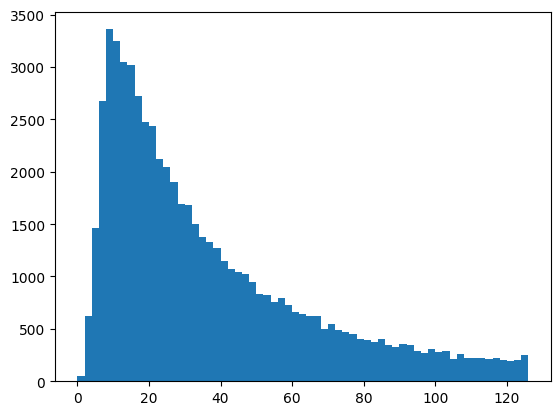

Testing Sentence Lengths: 


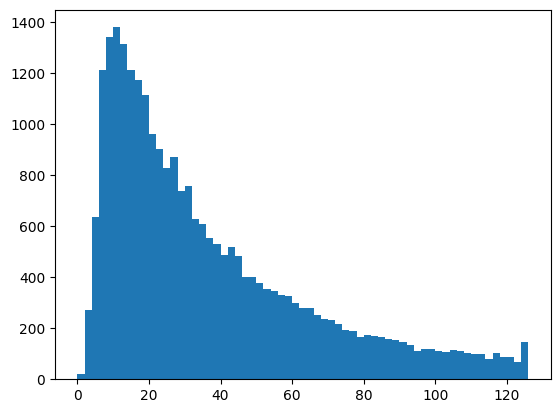

In [ ]:
print("Training Sentence Lengths: ")
plt.hist([ len(tokenizer.tokenize(sentence)) for sentence in data_main.train[DATA_COLUMN].to_list() ], bins=range(0,128,2))
plt.show()

print("Testing Sentence Lengths: ")
plt.hist([ len(tokenizer.tokenize(sentence)) for sentence in data_main.test[DATA_COLUMN].to_list() ], bins=range(0,128,2))
plt.show()

# Most of the samples in the dataset are less than 512 tokens

In [ ]:
data_train = data_main.train[DATA_COLUMN].to_list()
data_test = data_main.test[DATA_COLUMN].to_list()

max_len_train = max(len(tokenizer.tokenize(item)) for item in data_train)
max_len_test = max(len(tokenizer.tokenize(item)) for item in data_test)

max_len = max(max_len_train, max_len_test)

print("Maximum length of train data:", max_len_train)
print("Maximum length of test data:", max_len_test)
print("Maximum maximum length of both lists:",max_len)


Maximum length of train data: 359
Maximum length of test data: 359
Maximum maximum length of both lists: 359


In [ ]:
print("Truncated training sequences: ", sum([len(tokenizer.tokenize(sentence)) > max_len for sentence in data_main.train[DATA_COLUMN].to_list()]))
print("Truncated testing sequences: ", sum([len(tokenizer.tokenize(sentence)) > max_len for sentence in data_main.test[DATA_COLUMN].to_list()]))

Truncated training sequences:  0
Truncated testing sequences:  0


In [ ]:
# Creating a PyTorch dataset object to load the data into the Trainer API

class ClassificationDataset(Dataset):

    def __init__(self, text: list[str], target: list[str], model_name: str, max_len: int, label_map: dict[str, int]):
      super().__init__()

      self.text = text
      self.target = target
      self.tokenizer_name = model_name
      self.tokenizer = AutoTokenizer.from_pretrained(model_name)
      self.max_len = max_len
      self.label_map = label_map

    def __len__(self):
      return len(self.text)

    def __getitem__(self, item):
      text = str(self.text[item])
      text = " ".join(text.split())

      inputs = self.tokenizer(
          text,
          max_length=self.max_len,
          padding='max_length',
          truncation=True
      )

      # return input_ids, attention_mask, token_type_ids, label
      return InputFeatures(**inputs,label=self.label_map[self.target[item]])

In [ ]:
label_map = { v:index for index, v in enumerate(data_main.label_list) }
print(label_map)

{'Positive': 0, 'Mixed': 1, 'Negative': 2}


In [ ]:
# Create train/test Pytorch datasets

train_dataset = ClassificationDataset(
    data_main.train[DATA_COLUMN].to_list(),
    data_main.train[LABEL_COLUMN].to_list(),
    model_name,
    max_len,
    label_map
  )

test_dataset = ClassificationDataset(
    data_main.test[DATA_COLUMN].to_list(),
    data_main.test[LABEL_COLUMN].to_list(),
    model_name,
    max_len,
    label_map
  )

print(train_dataset[0])

InputFeatures(input_ids=[2, 29056, 16, 29738, 3833, 47969, 1943, 10887, 21284, 1947, 18157, 4506, 10334, 4986, 12854, 41507, 16, 4113, 14405, 13584, 4113, 14405, 25173, 12801, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [ ]:
input_ids = train_dataset[0].input_ids

tokenizer.decode(input_ids)

'[CLS] استثنايي. طاقم العمل ودودين الخدمة سريعة في اجراءات الدخول والمغادرة الخدمات متكاملة. عدم توفر الصحف عدم توفر انترنت مجاني [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] 

In [ ]:
# returns a pretrained model for finetuning in the trainer API
def model_init():
    model = AutoModelForSequenceClassification.from_pretrained(model_name, return_dict=True, num_labels=len(label_map))
    return model

In [ ]:
# some metrics we would like to see
# p should be of type EvalPrediction

def compute_metrics(p):
  preds = np.argmax(p.predictions, axis=1)
  assert len(preds) == len(p.label_ids)

  print(classification_report(p.label_ids, preds))
  print()
  print(confusion_matrix(p.label_ids, preds))

  macro_f1 = f1_score(p.label_ids, preds, average='macro')
  macro_precision = precision_score(p.label_ids, preds, average='macro')
  macro_recall = recall_score(p.label_ids, preds, average='macro')
  accuracy = accuracy_score(p.label_ids, preds)

  return {
      'macro_f1' : macro_f1,
      'macro_precision': macro_precision,
      'macro_recall': macro_recall,
      'accuracy': accuracy
  }

In [ ]:
# setting training parameters
training_args = TrainingArguments(
  output_dir= "train",
  adam_epsilon = 1e-8,
  learning_rate = 2e-5,
  report_to="tensorboard",
  fp16 = True,
  per_device_train_batch_size = 41,
  per_device_eval_batch_size = 41,
  gradient_accumulation_steps = 8,
  num_train_epochs = 1,
  warmup_ratio = 0,
  do_eval = True,
  evaluation_strategy = 'epoch',
  save_strategy = 'epoch',
  load_best_model_at_end = True,
  metric_for_best_model = 'macro_f1',
  greater_is_better = True
)

In [ ]:
# creating the trainer object
trainer = Trainer(
    model = model_init(),
    args = training_args,
    train_dataset = train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

(…)C-NLP/MARBERTv2/resolve/main/config.json:   0%|          | 0.00/757 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/654M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at UBC-NLP/MARBERTv2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# start the training
trainer.train()

Epoch,Training Loss,Validation Loss,Macro F1,Macro Precision,Macro Recall,Accuracy
0,No log,0.616674,0.727477,0.727503,0.730247,0.730155


              precision    recall  f1-score   support

           0       0.74      0.83      0.78      9724
           1       0.65      0.59      0.62      9761
           2       0.79      0.78      0.78      9780

    accuracy                           0.73     29265
   macro avg       0.73      0.73      0.73     29265
weighted avg       0.73      0.73      0.73     29265


[[8036 1380  308]
 [2307 5736 1718]
 [ 521 1663 7596]]


TrainOutput(global_step=208, training_loss=0.6960355318509616, metrics={'train_runtime': 2476.0829, 'train_samples_per_second': 27.577, 'train_steps_per_second': 0.084, 'total_flos': 1.2586490785499904e+16, 'train_loss': 0.6960355318509616, 'epoch': 1.0})

In [ ]:
trainer.evaluate()

              precision    recall  f1-score   support

           0       0.74      0.83      0.78      9724
           1       0.65      0.59      0.62      9761
           2       0.79      0.78      0.78      9780

    accuracy                           0.73     29265
   macro avg       0.73      0.73      0.73     29265
weighted avg       0.73      0.73      0.73     29265


[[8036 1380  308]
 [2307 5736 1718]
 [ 521 1663 7596]]


{'eval_loss': 0.6166738867759705,
 'eval_macro_f1': 0.7274770696171623,
 'eval_macro_precision': 0.7275029880560159,
 'eval_macro_recall': 0.7302469034435978,
 'eval_accuracy': 0.7301554758243636,
 'eval_runtime': 338.6625,
 'eval_samples_per_second': 86.413,
 'eval_steps_per_second': 2.108,
 'epoch': 1.0}

In [ ]:
print(label_map)

inv_label_map = { v:k for k, v in label_map.items()}

print(inv_label_map)

{'Positive': 0, 'Mixed': 1, 'Negative': 2}
{0: 'Positive', 1: 'Mixed', 2: 'Negative'}


In [ ]:
trainer.model.config.label2id = label_map
trainer.model.config.id2label = inv_label_map

SAVE_PATH = 'model'

In [ ]:
trainer.save_model(SAVE_PATH)
train_dataset.tokenizer.save_pretrained(SAVE_PATH)

('model/tokenizer_config.json',
 'model/special_tokens_map.json',
 'model/vocab.txt',
 'model/added_tokens.json',
 'model/tokenizer.json')

In [ ]:
pipe = pipeline(task="text-classification", model=SAVE_PATH, device=device, max_length=359, truncation=True, padding='max_length')

In [ ]:
tests = data_main.test[LABEL_COLUMN].to_list()
results = pipe(data_main.test[DATA_COLUMN].to_list())

preds = [res['label'] for res in results]

print("Real Testing Dataset labels: ", tests[:10])
print("Predicted Testing Dataset labels: ", preds[:10])

Real Testing Dataset labels:  ['Negative', 'Positive', 'Negative', 'Positive', 'Positive', 'Positive', 'Negative', 'Mixed', 'Negative', 'Mixed']
Predicted Testing Dataset labels:  ['Negative', 'Mixed', 'Mixed', 'Positive', 'Positive', 'Positive', 'Negative', 'Negative', 'Negative', 'Negative']


In [ ]:
print(classification_report(tests, preds))

              precision    recall  f1-score   support

       Mixed       0.65      0.59      0.62      9761
    Negative       0.79      0.78      0.78      9780
    Positive       0.74      0.83      0.78      9724

    accuracy                           0.73     29265
   macro avg       0.73      0.73      0.73     29265
weighted avg       0.73      0.73      0.73     29265



In [ ]:
list(label_map)

['Positive', 'Mixed', 'Negative']

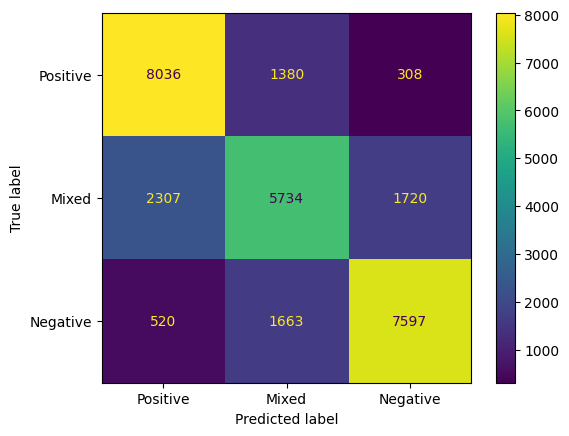

In [ ]:
cm = confusion_matrix(y_true=tests, y_pred=preds, labels=list(label_map))
cmd = ConfusionMatrixDisplay(cm, display_labels=list(label_map))
cmd.plot(values_format='')

In [ ]:
texts = ["خدمة العملاء ممتازة، والشحن سريع جداً. سعيد جداً بتجربتي.","المنتج لا يعمل بشكل جيد، ولاحظت العديد من المشاكل. أنا غير راضٍ."
,"بدأت جيدًا، لكن بعد فترة وجدت بعض المشاكل. يبدو أنه يحتاج إلى تحسين."]

results = pipe(texts)

for idx, result in enumerate(results):
  print(texts[idx], result)

خدمة العملاء ممتازة، والشحن سريع جداً. سعيد جداً بتجربتي. {'label': 'Positive', 'score': 0.9349363446235657}
المنتج لا يعمل بشكل جيد، ولاحظت العديد من المشاكل. أنا غير راضٍ. {'label': 'Negative', 'score': 0.7966440320014954}
بدأت جيدًا، لكن بعد فترة وجدت بعض المشاكل. يبدو أنه يحتاج إلى تحسين. {'label': 'Mixed', 'score': 0.5911381244659424}
